In [1]:
from __future__ import division
import cPickle as pkl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Quick inspection

In [3]:
cc = pkl.load(open('../tmp/dump_2009_class_1__raw_data_.pkl','rb'))
rd, ei = cc['raw_data'], cc['extra_info']

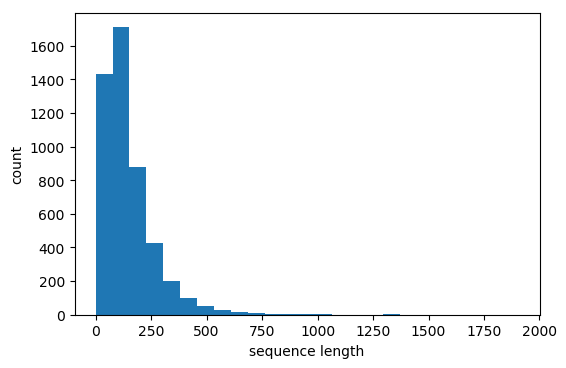

In [4]:
lenghts = [len(rd[k]) for k in rd.keys()]

plt.figure(dpi=100)
plt.hist(lenghts, bins=25)
plt.xlabel('sequence length')
plt.ylabel('count');

In [5]:
for i, k in enumerate(rd.keys()):
    print('* {}'.format(rd[k]))
    if i>3: break

* T0G0T0G1T0G2G0T2G0T2T0G0T0G2T0G2T0G1P0T0P0G0P0P0P0P0T0B0T0P0P0P0I0P0G0T0B0T0P0P0T0G0I0I0I0I0B0T0T0G1P0P0B0P0P0I1G0T0T0G0B0T0G0P0P0G0T0B0E0E0P0P
* O0O2G3P0P0P0P0G2P0P0G0P0G0T0G3G0G0E1E0S0S0S0G2G0E0E0S0P0P0S0I0G1P0P
* G0T0P0P0P0P0G0T1O0T0G0E0T0T0G0G0T0T0G1L0G0T0S0E0S0G0T0T0G1O0T0G3T0P0P0G0P0L0O0T0G0T0T1T0G0P0P0T0P0I0E0E0G0T0O0I0E0S0G0T0G0T0P0P0P0P0E0G0T0G0T0T0G0L0L0L0L0L0L0E0L0L0L0T0G0T0G0G0G0T0T1G0T0O0L0G0T0G0T0E0P0P0P0P0G0T0E0G0T0O0T0G0T0G0T0G0G0T0T0G0G0T0D0T0G0T0E0P0P0P0P0T0G0O0G0G0T0T0T0G0L0T0L0G0L0L0G0T0O0E0E0P0P0P0P0P0T0G0P0P0T0G1G0T0G0T0G0T0G0T0O0G0T0O
* T0G0P0P0T0E0P0P0G0T0I2G0T2T0G0P0P0P0P0P0P0E0P0P0P0T0G0P0P0T0P0P0E0E0S0S0E0E0E1T0G0G0T0E1E0E0P0P0P0P0E2E0T0G0G0T0P0P0P0P0P0P0P0P1E0I0I0G0T0I0T0G1T0G1E0I0T0G0P0T0G0P
* G0T0G0T0E0G0T0G0T0G0T0T0G2G0T1T0G0G0T0P0T0G0P0P0P0P0P0G0T0T0G2G0T1T0G0T0G0T0G0T0G0T0G0T0G0G0T0E0S0T0G1T0G2G0T2T0G0T0G0P0P0T0G0G0T0T0G2T0G0T0G2G0T0P0P0P0P0G0P0P0P0T1G0T2G0T1T0G0G0T1T0G


# Load raw data

In [6]:
def load_data(dump_files):
    """Extract sequences, extra info and patient id from dump pkl."""
    # Positive raw data load
    raw_data = []
    extra_info = []
    indexes = []
    for f in tqdm(dump_files, desc='Loading dump files'):
        _tmp = pkl.load(open(os.path.join('..', 'tmp', f), 'rb'))
        _raw_data, _extra_info = _tmp['raw_data'], _tmp['extra_info'].set_index('PIN')
        for k in _extra_info.index:
            if len(_raw_data[k])>0: # Skip empty sequences
                raw_data.append(_raw_data[k])
                extra_info.append([_extra_info.loc[k]['SEX'], _extra_info.loc[k]['AGE']])
                indexes.append(k)
#             else:
#                 print('empty {}'.format(k))
    return raw_data, extra_info, indexes

In [7]:
dump_files = filter(lambda x: 'raw_data' in x, os.listdir('../tmp/'))
positive_dump_files = filter(lambda x: 'class_1' in x, dump_files)
negative_dump_files = filter(lambda x: 'class_0' in x, dump_files)

Sequences should be like `['A', 8, 'M', 0, ...]` where letters are btos and numbers are weeks from one btos to another

In [8]:
pos_raw_data, pos_extra_info, pos_id = load_data(positive_dump_files)
print(len(pos_id), 'positive samples')

Loading dump files: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]

(28811, 'positive samples')


In [9]:
neg_raw_data, neg_extra_info, neg_id = load_data(negative_dump_files)
print(len(neg_id), 'negative samples')

Loading dump files: 100%|██████████| 1/1 [01:47<00:00, 107.96s/it]

(328841, 'negative samples')


# EDA
I want to use the negative samples with comparable length.

5%:61.0 | 95%965.0


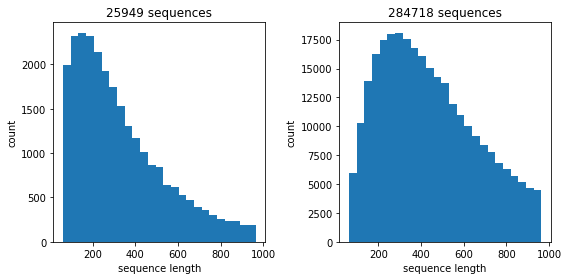

In [10]:
# Extracting the lenghts of the positive
lenghts = np.array([len(x) for x in pos_raw_data])

# Calculating 5-95 percentile
p5 = np.percentile(lenghts, 5)
p95 = np.percentile(lenghts, 95)
print('5%:{} | 95%{}'.format(p5, p95))

# Identifying the indexes
pos_idx595 = np.argwhere(np.logical_and(lenghts>=p5, lenghts<=p95)).ravel()
pos_lenghts = lenghts[pos_idx595]

# And for negative class as well
lenghts = np.array([len(x) for x in neg_raw_data])
neg_idx595 = np.argwhere(np.logical_and(lenghts>=p5, lenghts<=p95)).ravel()
neg_lenghts = lenghts[neg_idx595]


plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.hist(pos_lenghts, bins=25)
plt.title('{} sequences'.format(len(pos_lenghts)))
plt.xlabel('sequence length')
plt.ylabel('count')

plt.subplot(122)
plt.hist(neg_lenghts, bins=25)
plt.title('{} sequences'.format(len(neg_lenghts)))
plt.xlabel('sequence length')
plt.ylabel('count')

plt.tight_layout();

In [11]:
# Extract only the relevant samples
pos_raw_data595 = [pos_raw_data[i] for i in pos_idx595]
neg_raw_data595 = [neg_raw_data[i] for i in neg_idx595]

In [12]:
pos_extra_info595 = [pos_extra_info[i] for i in pos_idx595]
neg_extra_info595 = [neg_extra_info[i] for i in neg_idx595]

In [13]:
pos_id595 = [pos_id[i] for i in pos_idx595]
neg_id595 = [neg_id[i] for i in neg_idx595]

# Make Xy

In [17]:
# Bag-of-words representation
from sklearn.feature_extraction.text import CountVectorizer

# Adding extra info
def add_extra_info(X, extra_info):
    extra_info = np.array(extra_info)
    extra_info[:, 0] = np.where(extra_info[:,0] == 'F', 1, 0) # mapping F->1 | M->0
    extra_info = extra_info.astype(np.int)
    return np.hstack((X, extra_info))

# Create 3 data sets
for max_ngram in [1, 2, 3]:
    print('max ngram: ', max_ngram)
    bow = CountVectorizer(analyzer='char', ngram_range=[1, max_ngram])
    
    print('Creating BOW...')
    X1 = bow.fit_transform(pos_raw_data595).todense()
    print(X1.shape)

    X0 = bow.transform(neg_raw_data595).todense()
    print(X0.shape)

    print('Adding extra info...')
    X1 = add_extra_info(X1, pos_extra_info595)
    print(X1.shape)

    X0 = add_extra_info(X0, neg_extra_info595)
    print(X0.shape)
    
    # Feature names
    print('Feature names:')
    feat_names = bow.vocabulary_.keys()
    feat_names.append('SEX')
    feat_names.append('AGE')
    print(feat_names)
    
    print('Save dataset')
    pd.DataFrame(data=X1, index=pos_id595, columns=feat_names).to_csv('BOW_{}-gram_class1.csv'.format(max_ngram))
    pd.DataFrame(data=X0, index=neg_id595, columns=feat_names).to_csv('BOW_{}-gram_class0.csv'.format(max_ngram))
    print('done.')

('max ngram: ', 1)
Creating BOW...
(25949, 17)
(284718, 17)
Adding extra info...
(25949, 19)
(284718, 19)
Feature names:
[u's', u'r', u'b', u'e', u'd', u'g', u'0', u'i', u'h', u'l', u'o', u'1', u'p', u'3', u'2', u't', u'4', 'SEX', 'AGE']
Save dataset
done.
('max ngram: ', 2)
Creating BOW...
(25949, 127)
(284718, 127)
Adding extra info...
(25949, 129)
(284718, 129)
Feature names:
[u's0', u'h0', u'3e', u'r2', u'0t', u'd4', u's4', u'd2', u'd3', u'd0', u'd1', u'1p', u'1s', u'1r', u'1t', u'4i', u'3i', u't', u'0', u'1b', u'1e', u'4', u'1g', u'h', u'1i', u'i', u'1l', u'1o', u'1d', u'p2', u'g4', u'g3', u'g2', u'g1', u'g0', u'4d', u'b', u'2', u'2t', u'p3', u'p0', u'p1', u'2p', u'd', u'2r', u'2s', u'3g', u't4', u't2', u'l', u't0', u't1', u'2d', u'2e', u'l4', u'2g', u'l2', u'l3', u'l0', u'l1', u'2l', u'3d', u'2i', u'4o', u'4e', u't3', u'b4', u'b0', u'b1', u'b2', u'b3', u'p4', u'p', u'3s', u'3r', u's1', u'3p', u'4l', u'3t', u'1', u'3', u'r', u'3o', u'3l', u'3b', u'o4', u'o3', u'o2', u'o1', u'o0', 

# Load the desired BOW dataset

In [25]:
ngram=3

df0 = pd.read_csv('BOW-datasets/BOW_{}-gram_class0.csv'.format(ngram), header=0, index_col=0)
df1 = pd.read_csv('BOW-datasets/BOW_{}-gram_class1.csv'.format(ngram), header=0, index_col=0)

X0 = df0.values
X1 = df1.values
feat_names = df0.columns

print(X0.shape)
print(X1.shape)

(284718, 854)
(25949, 854)


# Learning

In [34]:
# Create a balanced training set
n = X1.shape[0]

# Subsample X1
idx = np.arange(n)
np.random.shuffle(idx)
X1_small = X1[idx, :]
id1 = df1.index[idx]

# Subsample X0
idx = np.arange(n)
np.random.shuffle(idx)
X0_small = X0[idx, :]
id0 = df0.index[idx]

# Stack them
X_small = np.vstack((X1_small, X0_small))
y_small = np.hstack((np.ones(X1_small.shape[0]), np.zeros(X0_small.shape[0])))
id_small = id1.tolist()+id0.tolist()
print(X_small.shape)
print(y_small.shape)

(51898, 854)
(51898,)


In [35]:
# pd.DataFrame(X_small, index=id_small, columns=feat_names).to_csv('BOW-datasets/X_balanced.csv')
# pd.DataFrame(y_small, index=id_small, columns=['Class']).to_csv('BOW-datasets/y_balanced.csv')

In [36]:
# Simple assessment
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

pipe = Pipeline([('pp', StandardScaler()), ('mdl', LogisticRegression())])

scores = cross_validate(pipe, X_small, y_small, cv=5, n_jobs=-1)
print('Training: avg score: {:2.3f} +- {:2.3f}'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))
print('Validation: avg score: {:2.3f} +- {:2.3f}'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))

Training: avg score: 0.910 +- 0.000
Validation: avg score: 0.903 +- 0.002


In [37]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('pp', StandardScaler()),
                 ('mdl', RandomForestClassifier(n_estimators=500, max_features=0.25, n_jobs=-1))])

scores = cross_validate(pipe, X_small, y_small, cv=5)
print('Training: avg score: {:2.3f} +- {:2.3f}'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))
print('Validation: avg score: {:2.3f} +- {:2.3f}'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))

Training: avg score: 1.000 +- 0.000
Validation: avg score: 0.899 +- 0.002


In [38]:
# Single split with GB and early stopping
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

params = {'mdl__max_depth': map(int, np.linspace(10, 100, 15)),
          'mdl__max_features': ['log2', 'sqrt', 0.5, None]},

pipe = Pipeline([('pp', StandardScaler()),
                 ('mdl', GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,
                                                    validation_fraction=0.1,
                                                    n_iter_no_change=10))])
pipe_cv = GridSearchCV(pipe, param_grid=params, n_jobs=-1)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
train_idx, test_idx = next(sss.split(X_small, y_small))

pipe_cv.fit(X_small[train_idx, :], y_small[train_idx])

print('Boosting iter: {}'.format(pipe_cv.best_estimator_.steps[1][1].n_estimators_))
print('Training score: {:2.3f} '.format(accuracy_score(pipe_cv.predict(X_small[train_idx, :]), y_small[train_idx])))
print('Validation score: {:2.3f}'.format(accuracy_score(pipe_cv.predict(X_small[test_idx, :]), y_small[test_idx])))

/home/samu/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:714: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Boosting iter: 79
Training score: 0.978 
Validation score: 0.906


In [39]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=512, n_jobs=-1, max_features=0.1,)

forest.fit(X_small, y_small)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
# workaround
# forest = pipe_cv.best_estimator_.steps[1][1]

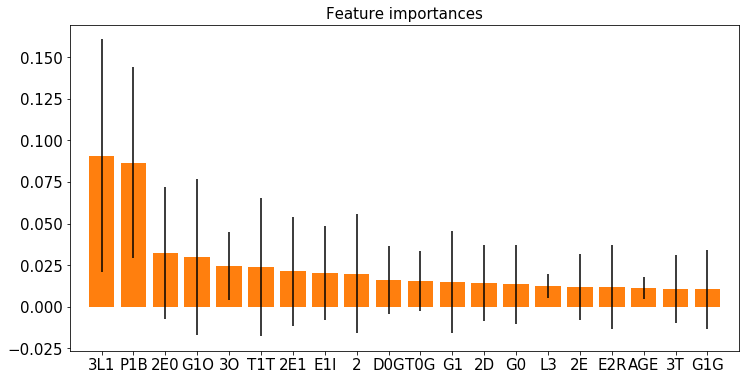

In [40]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(X_small.shape[1]):
#     print("%d. feature %s (%f)" % (f + 1, feat_names[f], importances[indices[f]]))

# Plot the feature importances of the forest
top_k = 20
plt.figure(figsize=(12, 6))
plt.title("Feature importances", fontsize=15)
plt.bar(range(top_k), importances[indices][:top_k], yerr=std[indices[:top_k]], align="center")
plt.bar(range(top_k), importances[indices][:top_k], align="center")
plt.xticks(range(top_k), [s.upper() for s in np.array(feat_names)[indices][:top_k]], fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([-1, top_k]);

# Dataviz

In [41]:
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

sss = StratifiedShuffleSplit(n_splits=1, test_size=500)
_, _idx = next(sss.split(X_small, y_small))

In [42]:
pp = StandardScaler()
# tsne = TSNE(n_components=3, perplexity=100, init='pca')
isomap = Isomap(n_components=3)
pipe = Pipeline([('pp', pp), ('dr', isomap)])

x_r = pipe.fit_transform(X_small[_idx, :])

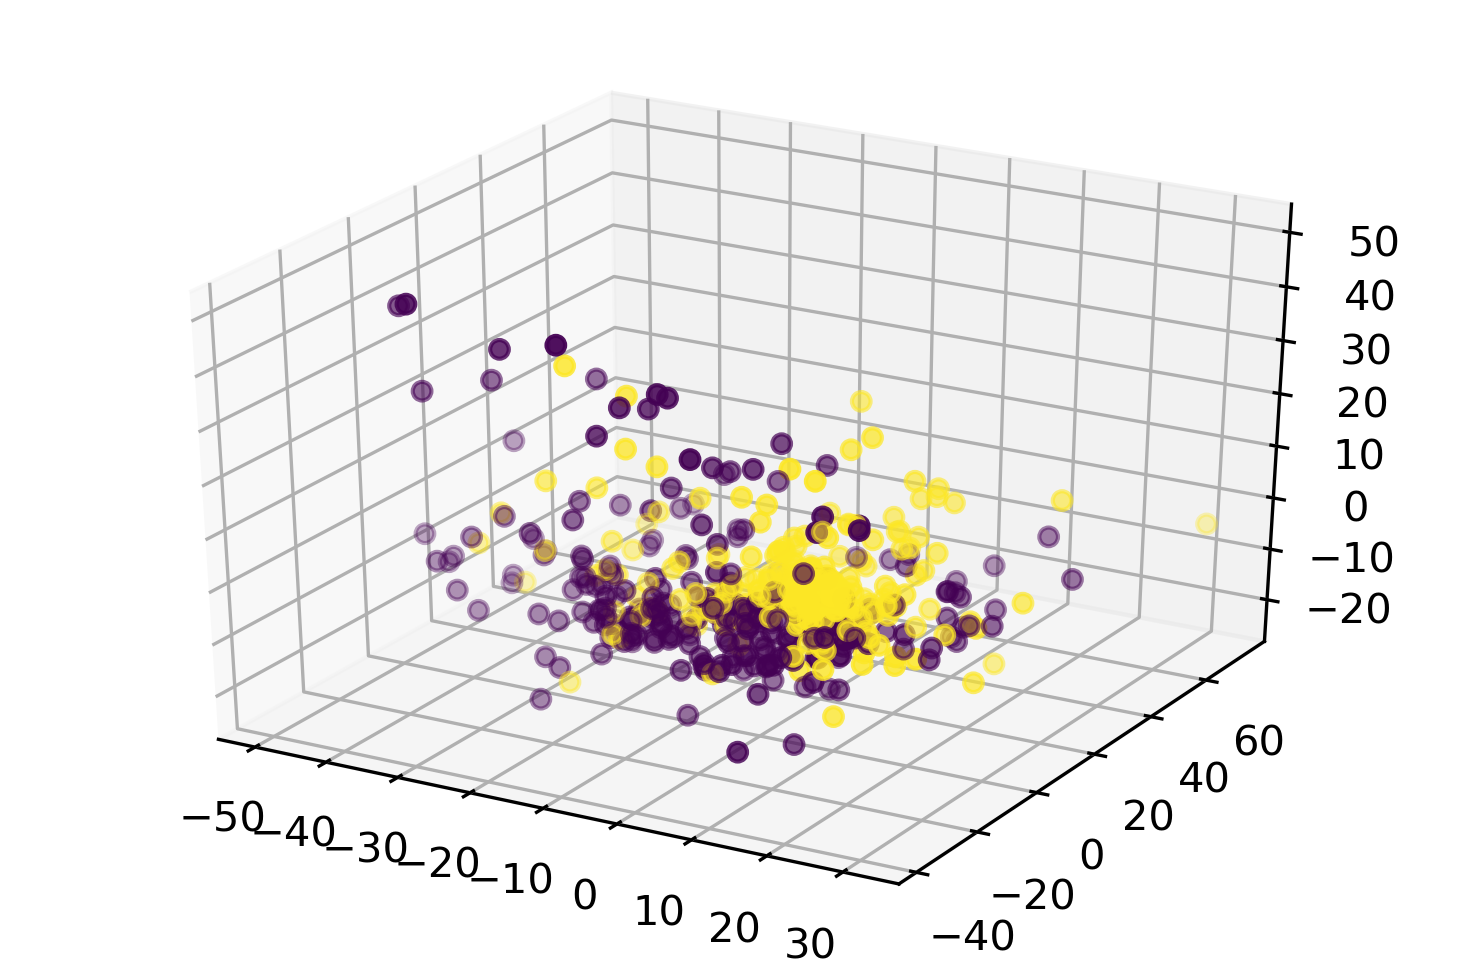

In [43]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

xs = x_r[:, 0]
ys = x_r[:, 1]
zs = x_r[:, 2]
ax.scatter(xs, ys, zs, c=y_small[_idx]);